In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# to run async code in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

API_KEY = None
SECRET_KEY = None

import os
from dotenv import load_dotenv

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [2]:
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from alpaca.trading.client import TradingClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.corporate_actions import CorporateActionsClient
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.trading.stream import TradingStream
from alpaca.data.live.stock import StockDataStream

from alpaca.data.requests import (
    CorporateActionsRequest,
    StockBarsRequest,
    StockQuotesRequest,
    StockTradesRequest,
)

from alpaca.data.enums import Adjustment

In [3]:
symbol = 'TSLA'

In [4]:
stock_historical_data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

now = datetime.now(ZoneInfo("America/New_York"))

req = StockBarsRequest(
    symbol_or_symbols = [symbol],
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Hour), 
    start = datetime(2018, 1, 22, tzinfo=ZoneInfo('America/New_York')),                     
    limit = None,    
    adjustment=Adjustment('all')                                           
)
df_adj = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_adj = df_adj.drop(columns=['symbol'])

In [5]:
print(df_adj.info())
print(df_adj.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29123 entries, 2018-01-22 09:00:00+00:00 to 2025-06-23 19:00:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         29123 non-null  float64
 1   high         29123 non-null  float64
 2   low          29123 non-null  float64
 3   close        29123 non-null  float64
 4   volume       29123 non-null  float64
 5   trade_count  29123 non-null  float64
 6   vwap         29123 non-null  float64
dtypes: float64(7)
memory usage: 1.8 MB
None
open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
dtype: int64


In [6]:
# Filter to only regular market hours (e.g., 9:30 to 16:00 New York time)
df_adj = df_adj.between_time("09:30", "16:00")

# Remove rows where close > high (bad ticks/outliers)
df_adj = df_adj[df_adj['close'] <= df_adj['high']]

# Remove or fill NaNs (forward fill, then backward fill if any remain)
df_adj = df_adj.ffill().bfill()

In [7]:
import ta

# Trend Indicators
df_adj['sma_20'] = ta.trend.sma_indicator(df_adj['close'], window=20)
df_adj['ema_20'] = ta.trend.ema_indicator(df_adj['close'], window=20)

macd = ta.trend.macd(df_adj['close'])
macd_signal = ta.trend.macd_signal(df_adj['close'])
macd_diff = ta.trend.macd_diff(df_adj['close'])
df_adj['macd'] = macd
df_adj['macd_signal'] = macd_signal
df_adj['macd_hist'] = macd_diff

# Momentum Indicators
df_adj['rsi_14'] = ta.momentum.rsi(df_adj['close'], window=14)

stoch_k = ta.momentum.stoch(df_adj['high'], df_adj['low'], df_adj['close'], window=14, smooth_window=3)
stoch_d = ta.momentum.stoch_signal(df_adj['high'], df_adj['low'], df_adj['close'], window=14, smooth_window=3)
df_adj['stoch_k'] = stoch_k
df_adj['stoch_d'] = stoch_d

# Volatility Indicators
bb = ta.volatility.BollingerBands(df_adj['close'], window=20, window_dev=2)
df_adj['bb_upper'] = bb.bollinger_hband()
df_adj['bb_middle'] = bb.bollinger_mavg()
df_adj['bb_lower'] = bb.bollinger_lband()

df_adj['atr_14'] = ta.volatility.average_true_range(df_adj['high'], df_adj['low'], df_adj['close'], window=14)

# Volume-based Indicators
df_adj['obv'] = ta.volume.on_balance_volume(df_adj['close'], df_adj['volume'])
df_adj['volume_pct_change'] = df_adj['volume'].pct_change() * 100

# Fill any new NaNs from indicators
df_adj = df_adj.ffill().bfill()

In [8]:
# Lag Features: previous bar values
for t in range(1, 6):  # Create lag features for t-1 to t-5
    df_adj[f'close_t-{t}'] = df_adj['close'].shift(t)
    df_adj[f'volume_t-{t}'] = df_adj['volume'].shift(t)
    df_adj[f'high_t-{t}'] = df_adj['high'].shift(t)
    df_adj[f'low_t-{t}'] = df_adj['low'].shift(t)
    df_adj[f'open_t-{t}'] = df_adj['open'].shift(t) 

# Rolling statistics
df_adj['close_mean_10'] = df_adj['close'].rolling(window=10).mean()
df_adj['close_std_10'] = df_adj['close'].rolling(window=10).std()

df_adj['volume_mean_10'] = df_adj['volume'].rolling(window=10).mean()
df_adj['volume_std_10'] = df_adj['volume'].rolling(window=10).std()

df_adj['close_min_10'] = df_adj['close'].rolling(window=10).min()
df_adj['close_max_10'] = df_adj['close'].rolling(window=10).max()

# Fill any new NaNs from lag/rolling features
df_adj = df_adj.ffill().bfill()

In [9]:
# Time Features: Day of week and hour of day as cyclical features
df_adj['day_of_week'] = df_adj.index.dayofweek
df_adj['hour_of_day'] = df_adj.index.hour

# Cyclical encoding for day of week (0=Monday, 6=Sunday)
df_adj['day_of_week_sin'] = np.sin(2 * np.pi * df_adj['day_of_week'] / 7)
df_adj['day_of_week_cos'] = np.cos(2 * np.pi * df_adj['day_of_week'] / 7)

# Cyclical encoding for hour of day (market hours: 9 to 16)
df_adj['hour_of_day_sin'] = np.sin(2 * np.pi * (df_adj['hour_of_day'] - 9) / 7)
df_adj['hour_of_day_cos'] = np.cos(2 * np.pi * (df_adj['hour_of_day'] - 9) / 7)

# Drop raw day/hour columns if not needed
# df_adj = df_adj.drop(columns=['day_of_week', 'hour_of_day'])

In [10]:
# Mark 1 if the price will go up at least 1% in the next n bars, measured in log returns.
n = 3  # number of bars ahead
threshold = np.log(1 + 0.01)  # A 1% price gain is equivalent to log(1.01)

df_adj['target'] = 0  # initialize target column

i = 0
while i < len(df_adj) - n:
    # compute log return over next n bars
    future_log_return = np.log(df_adj['close'].iloc[i + n] / df_adj['close'].iloc[i])
    
    if future_log_return >= threshold:
        df_adj.at[df_adj.index[i], 'target'] = 1
        i += n  # skip next n bars to avoid overlapping
    else:
        i += 1

In [166]:
# AFTER CREATING TARGET ALWAYS, do not normalize before computing the target
from sklearn.preprocessing import StandardScaler

# Separate features and target
features = df_adj.drop(columns=['target'])
target = df_adj['target']

# Scale only the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Reconstruct the DataFrame with scaled features and original target
df_scaled = pd.DataFrame(features_scaled, index=features.index, columns=features.columns)
df_scaled['target'] = target

In [174]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

X = df_scaled.drop(columns=['target'])
y = df_scaled['target']

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Calculate scale_pos_weight to handle class imbalance
# scale_pos_weight = (number of 0s) / (number of 1s)
n_zeros = (y == 0).sum()
n_ones = (y == 1).sum()
scale_pos_weight = n_zeros / n_ones if n_ones > 0 else 1

# XGBoost classifier with class weight
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

# Hyperparameter grid for random search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    n_jobs=-1,
    cv=tscv,
    verbose=2,
    random_state=42
)

random_search.fit(X, y)

print("Best parameters found:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

# Evaluate on the last fold as a holdout test
split_idx = list(tscv.split(X))[-1]
X_train, X_test = X.iloc[split_idx[0]], X.iloc[split_idx[1]]
y_train, y_test = y.iloc[split_idx[0]], y.iloc[split_idx[1]]

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Best cross-validation accuracy: 0.8533333333333333
Test Accuracy: 0.9843971631205674
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       600
           1       0.94      0.96      0.95       105

    accuracy                           0.98       705
   macro avg       0.96      0.98      0.97       705
weighted avg       0.98      0.98      0.98       705



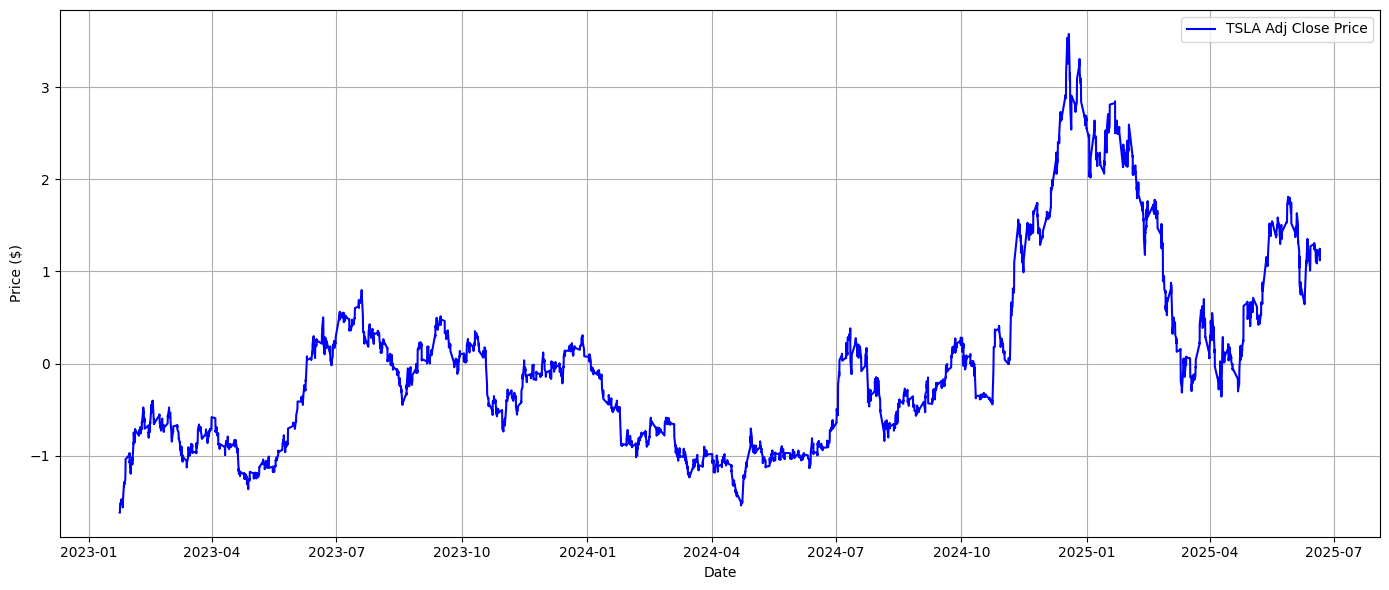

In [63]:
# Plot the closing prices
plt.figure(figsize=(14, 6))
plt.plot(df_adj['close'], label=symbol+' Adj Close Price', color='blue')

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
import asyncio

# Create a stream connection (for paper account)
stream = StockDataStream(API_KEY, SECRET_KEY)

# Define the handler for bar data (1-minute bars, for example)
async def handle_bars(bar):
    print(f"{bar.symbol} | Time: {bar.timestamp} | Open: {bar.open} | Close: {bar.close}")

# Subscribe to minute bars for a symbol 
stream.subscribe_bars(handle_bars, symbol)

# Start the stream
async def main():
    await stream.run()

asyncio.run(main())


keyboard interrupt, bye


TimeoutError: 